# TCGA & GDSC filtering and normalization

In [1]:
import numpy as np
import pandas as pd
import os

# preprocess of TCGA: gep, drug

## preprocess gep of TCGA:

In [2]:
# raw data
path_tcga = "../data_input/tcga"
tpm_tcga = pd.read_csv(os.path.join(path_tcga, 'tcga_RSEM_gene_tpm.gz'),
                       sep="\t",
                       index_col=0) 
print(f'tpm_tcga.shape: {tpm_tcga.shape}')

tpm_tcga.shape: (60498, 10535)


In [3]:
# process gep: genefile downloaded from HGNS

genefile = "../data_input/HGNC_genesSymbol_conversion.txt"
genefile = pd.read_csv(genefile, sep = "\t")
print(f"genefile.head: {genefile.head(2)}")
#
# process genefile
print(genefile.columns)
genefile_v1 = genefile.loc[:, ['Approved symbol', 'Ensembl gene ID']]
genefile_v1.columns = ["gene_symbol", "gene_ensemble"]
#
mask_na = genefile_v1.gene_ensemble.isna()
genefile_v2 = genefile_v1.loc[~mask_na, :]
mask_dup = genefile_v2.gene_ensemble.duplicated()
genefile_v3 = genefile_v2.loc[~mask_dup, :]
#
print(f"genefile_v3.shape: {genefile_v3.shape}")
# CONCLUSION: only 30K genes, about half of the TPM genes, but enough for analysis

genefile.head:       HGNC ID Approved symbol           Approved name    Status  \
0      HGNC:5            A1BG  alpha-1-B glycoprotein  Approved   
1  HGNC:37133        A1BG-AS1    A1BG antisense RNA 1  Approved   

              Previous symbols Alias symbols RefSeq IDs  Ensembl gene ID  \
0                          NaN           NaN  NM_130786  ENSG00000121410   
1  NCRNA00181, A1BGAS, A1BG-AS      FLJ23569  NR_015380  ENSG00000268895   

   NCBI Gene ID  
0           1.0  
1      503538.0  
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Status',
       'Previous symbols', 'Alias symbols', 'RefSeq IDs', 'Ensembl gene ID',
       'NCBI Gene ID'],
      dtype='object')
genefile_v3.shape: (39012, 2)


In [4]:
# process gep: merge

tpm_tcga.index = tpm_tcga.index.str.extract(pat = "(\w+)", expand = False)
tpm_tcga.columns = tpm_tcga.columns.str[0:12]
#
tpm_tcga_v1 = pd.merge(tpm_tcga, genefile_v3, left_index = True, right_on = "gene_ensemble", how = "inner")
tpm_tcga_v1.set_index("gene_symbol", drop = True, inplace = True)
#
print(f"tpm_tcga_v1.shape: {tpm_tcga_v1.shape}")

tpm_tcga_v1.shape: (38502, 10536)


In [5]:
tpm_tcga_v1.head(2)

,TCGA-19-1787,TCGA-S9-A7J2,TCGA-G3-A3CH,TCGA-EK-A2RE,TCGA-44-6778,TCGA-F4-6854,TCGA-AB-2863,TCGA-C8-A1HL,TCGA-EW-A2FS,TCGA-IR-A3L7,...,TCGA-A8-A09K,TCGA-61-1907,TCGA-IB-7885,TCGA-95-7947,TCGA-VQ-AA6F,TCGA-BR-8588,TCGA-24-2254,TCGA-DD-A115,TCGA-FV-A3I0,gene_ensemble
gene_symbol,,,,,,,,,,,,,,,,,,,,,
LINC02082,-9.9658,0.2998,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-1.9379,-9.9658,-9.9658,ENSG00000242268
ST8SIA5-DT,-3.8160,-3.0469,-9.9658,-9.9658,-5.5735,-9.9658,-3.4580,-9.9658,-5.0116,-9.9658,...,-9.9658,-9.9658,-9.9658,-6.5064,-9.9658,-9.9658,-5.5735,-9.9658,-9.9658,ENSG00000270112


## Preprocess pheno treated by a single drug in TCGA

In [6]:
# raw data
path_tcga = "../data_input/tcga"
snv_nonsilence_tcga = pd.read_csv(os.path.join(
    path_tcga, 'mc3.v0.2.8.PUBLIC.nonsilentGene.xena.gz'),
                                  sep='\t',
                                  index_col=0)
# https://xenabrowser.net/datapages/?dataset=tcga_RSEM_gene_tpm&host=https%3A%2F%2Ftoil.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443
# log2(tpm+0.001)
# tpm_tcga = pd.read_csv(os.path.join(path_tcga, 'tcga_RSEM_gene_tpm.gz'),
#                        sep="\t",
#                      index_col=0) 
pheno_tcga_raw = pd.read_csv(os.path.join(path_tcga, "pheno_TCGApanCancer.tsv"),
                    sep="\t")
print(f"pheno_tcga_raw.shape: {pheno_tcga_raw.shape}")
print(f'snv_nonsilence_tcga.shape: {snv_nonsilence_tcga.shape}')
# print(f'tpm_tcga.shape: {tpm_tcga.shape}')

# TCGA response data cleaned by paper: Evaluating the molecule-based prediction of drug in cancer
f = "../data_input/Evaluating the molecule-based prediction of drug in cancer_supplementary_tables.xlsx"
drug_tcga = pd.read_excel(f, sheet_name = "Table S1",skiprows = 1)
drug_response_tcga = pd.read_excel(f, sheet_name = "Table S2", skiprows = 1)
drug_response_inconsist_tcga = pd.read_excel(f, sheet_name = "Table S3", skiprows = 1)

pheno_tcga_raw.shape: (10967, 99)
snv_nonsilence_tcga.shape: (40543, 9104)


In [7]:
# id intersection of response, pheno, snv, gep

from functools import reduce

id_pheno = pheno_tcga_raw["Patient ID"]
id_snv = snv_nonsilence_tcga.columns.str[0:12]
id_gep = tpm_tcga_v1.columns
id_response = drug_response_tcga.bcr_patient_barcode

print(f"id_snv.shape: {id_snv.unique().shape}; id_gep.shape: {id_gep.unique().shape}, id_response.shape: {id_response.unique().shape}")

id_intersect_TCGA = reduce(np.intersect1d, 
                      [id_pheno, id_snv, id_gep])
print(f"# of patients TCGA: {id_intersect_TCGA.shape}")


id_intersect = reduce(np.intersect1d, 
                      [id_pheno, id_snv, id_gep, id_response])
print(f"# of patients included: {id_intersect.shape}")

id_snv.shape: (9104,); id_gep.shape: (9782,), id_response.shape: (1197,)
# of patients TCGA: (8347,)
# of patients included: (1018,)


In [8]:
#
keys_grouper = ["bcr_patient_barcode"]
response_v1 = drug_response_tcga.loc[drug_response_tcga.bcr_patient_barcode.isin(id_intersect), :]
response_per_pt_tcga = response_v1.groupby(keys_grouper)["drug_name"].apply(lambda x: ":".join(x))
response_per_pt_tcga = pd.DataFrame(response_per_pt_tcga).reset_index()
print(f"response_per_pt_tcga.shape: {response_per_pt_tcga.shape}")

mask_single_drug = ~(response_per_pt_tcga.drug_name.str.contains(":|,| "))
response_per_pt_tcga_singleDrug = response_per_pt_tcga.loc[mask_single_drug, :]
print(f"response_per_pt_tcga_singleDrug.shape: {response_per_pt_tcga_singleDrug.shape}")

singleDrug_tcga = response_per_pt_tcga_singleDrug.drug_name.unique()
print(f"singleDrug_tcga: {singleDrug_tcga}")
print(response_per_pt_tcga_singleDrug.head())

response_per_pt_tcga.shape: (1018, 2)
response_per_pt_tcga_singleDrug.shape: (404, 2)
singleDrug_tcga: ['Carboplatin' 'Gemcitabine' 'Sorafenib' 'Everolimus' 'Sunitinib'
 'Fluorouracil' 'Cisplatin' 'Dasatinib' 'Paclitaxel' 'Docetaxel'
 'Erlotinib' 'Oxaliplatin' 'Trastuzumab' 'Anastrozole' 'Folfox'
 'Capecitabine' 'FOLFOX' 'Temsirolimus' 'Pazopanib' 'Zoledronate'
 'Cetuximab' 'Cyclophosphamide' 'Levothyroxine' 'BCG' 'Etoposide'
 'Doxorubicin' 'Leuprolide' 'triptorelin' 'MEL-44' 'Aldesleukin'
 'Temozolomide' 'doxorubicin/cyclophosphamide' 'Bevacizumab'
 'Liothyronine' 'Tamoxifen' 'Pamidronate' 'Dacarbazine' 'Lomustine'
 'Alverine' 'PNU-159548' 'Fotemustine' 'PI-88' 'Goserelin' 'Bicalutamide'
 'Ipilimumab' 'Topotecan' 'Vinorelbine' 'Themozolomide' 'Ifosfamide'
 'Carmustine' 'px-866' 'nivolumab' 'Melphalan' 'Bleomycin']
   bcr_patient_barcode    drug_name
10        TCGA-2G-AAF1  Carboplatin
50        TCGA-2L-AAQA  Gemcitabine
51        TCGA-2L-AAQE  Gemcitabine
52        TCGA-2L-AAQI  Gemci

In [9]:
mask1 = pheno_tcga_raw["Patient ID"].isin(response_per_pt_tcga_singleDrug.bcr_patient_barcode)
pheno_tcga_raw.loc[mask1, "TCGA PanCanAtlas Cancer Type Acronym"].unique().shape

(24,)

In [10]:
response_per_pt_tcga_singleDrug.head(3)

,bcr_patient_barcode,drug_name
10,TCGA-2G-AAF1,Carboplatin
50,TCGA-2L-AAQA,Gemcitabine
51,TCGA-2L-AAQE,Gemcitabine


# preprocess GDSC

In [12]:
# GDSC data
drug_gdsc = pd.read_csv("../data_input/GDSC/screened_compounds_rel_8.4.csv")
cell_anno_gdsc = pd.read_excel("../data_input/GDSC/Cell_Lines_Details.xlsx", sheet_name = "Cell line details")
ic50_gdsc2 = pd.read_excel("../data_input/GDSC/GDSC2_fitted_dose_response_24Jul22.xlsx")
ic50_gdsc1 = pd.read_excel("../data_input/GDSC/GDSC1_fitted_dose_response_24Jul22.xlsx")

/mnt/disk8t/Anaconda/envs/tf/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


## filtering drugs using both gdsc and singleDrug tcga data

In [13]:
drug_gdsc["drug_and_alias"] = np.where(drug_gdsc.DRUG_NAME.isna(),
                                       drug_gdsc.SYNONYMS,
                                       drug_gdsc.DRUG_NAME + ", " + drug_gdsc.SYNONYMS)
print(sum(drug_gdsc["drug_and_alias"].isna()))

#
d = drug_gdsc["drug_and_alias"].astype(str)
drug_gdsc_flat = [s.strip() for item in d for s in item.split(",")]
print(len(drug_gdsc_flat))

202
1513


In [14]:
# drugs intersected
drug_intersect = np.intersect1d(drug_gdsc_flat, singleDrug_tcga)
print("# of intersected drugs: {}".format(len(drug_intersect)))
print(" intersected drugs: {}".format(drug_intersect))
# no fluorouracil, because fluorouracil is named 5-Fluorouracil in gdsc

# drug_tcga_unique
drug_tcga_unique = np.setdiff1d(singleDrug_tcga, drug_gdsc_flat)
print(f"length drug_tcga_unique: {len(drug_tcga_unique)}")
# I checked these drugs mannually, can i can add no drug to the intersected drug more

# of intersected drugs: 21
 intersected drugs: ['Bicalutamide' 'Cetuximab' 'Cisplatin' 'Cyclophosphamide' 'Dacarbazine'
 'Dasatinib' 'Docetaxel' 'Doxorubicin' 'Erlotinib' 'Etoposide'
 'Gemcitabine' 'Oxaliplatin' 'Paclitaxel' 'Pazopanib' 'Sorafenib'
 'Sunitinib' 'Tamoxifen' 'Temozolomide' 'Temsirolimus' 'Vinorelbine'
 'Zoledronate']
length drug_tcga_unique: 33


In [15]:
# add Fluorouracil to drug_intesect. and i will revise 5-Fluorouracil -> Fluorouracil latter in gdsc
print("Fluorouracil" in singleDrug_tcga)
#
drug_intersect = np.append(drug_intersect, "Fluorouracil")
drug_intersect = drug_intersect[drug_intersect != "nan"]
print("len of drug_intersect: {}".format(len(drug_intersect)))

True
len of drug_intersect: 22


## create full GDSC data comprised of GDSC1 & GDSC2

In [16]:
ic50_gdsc2.head(2)

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
0,GDSC2,401,18945558,683667,PFSK-1,SIDM01132,MB,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-1.462148,0.930105,0.088999,0.432482
1,GDSC2,401,18945796,684052,A673,SIDM00848,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-4.869447,0.614932,0.111423,-1.420322


In [17]:
# merge ic50_gdsc1/2 to a single file

print(f"ic50_gdsc1.shape: {ic50_gdsc1.shape}")
print(f"ic50_gdsc2.shape: {ic50_gdsc2.shape}")
print(f"is ic50_gdsc1.columns == ic50_gdsc1.columns: {(ic50_gdsc1.columns == ic50_gdsc1.columns).all()}")

keys_merge = ["SANGER_MODEL_ID", "DRUG_NAME"]
# BE CAREFULL: DRUG_ID is the order in each dataset, and is inconsistent between datasets

mask_dup1 = ic50_gdsc1.loc[:, keys_merge].duplicated(keep = "first")
mask_dup2 = ic50_gdsc2.loc[:, keys_merge].duplicated(keep = "first")
print(f"#duplications in gdsc1: {mask_dup1.sum()}")
print(f"#duplications in gdsc1: {mask_dup2.sum()}")
# Why do some drugs have multiple Drug IDs? https://www.cancerrxgene.org/faq 

ic50_gdsc1["id_cell_drug"] = ic50_gdsc1["SANGER_MODEL_ID"] + ":" + ic50_gdsc1["DRUG_NAME"]
ic50_gdsc2["id_cell_drug"] = ic50_gdsc2["SANGER_MODEL_ID"] + ":" + ic50_gdsc2["DRUG_NAME"]

ic50_gdsc1_rmDup = ic50_gdsc1.loc[~ic50_gdsc1["id_cell_drug"].duplicated(), :]
ic50_gdsc2_rmDup = ic50_gdsc2.loc[~ic50_gdsc2["id_cell_drug"].duplicated(), :]
print(f"ic50_gdsc1_rmDup.shape: {ic50_gdsc1_rmDup.shape}")
print(f"ic50_gdsc2_rmDup.shape: {ic50_gdsc2_rmDup.shape}")

mask_overlap_id = ic50_gdsc1_rmDup.id_cell_drug.isin(ic50_gdsc2_rmDup.id_cell_drug)
print(f"#mask_overlap_id: {mask_overlap_id.sum()}")

ic50_gdsc_full = pd.concat(
    [ic50_gdsc2_rmDup, ic50_gdsc1_rmDup.loc[~mask_overlap_id, :]],
    axis = 0
)
print(f"ic50_gdsc_full.shape: {ic50_gdsc_full.shape}")

ic50_gdsc1.shape: (333161, 19)
ic50_gdsc2.shape: (242036, 19)
is ic50_gdsc1.columns == ic50_gdsc1.columns: True
#duplications in gdsc1: 18067
#duplications in gdsc1: 6288
ic50_gdsc1_rmDup.shape: (315094, 20)
ic50_gdsc2_rmDup.shape: (235748, 20)
#mask_overlap_id: 89476
ic50_gdsc_full.shape: (461366, 20)


In [18]:
ic50_gdsc_full.head()

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE,id_cell_drug
0,GDSC2,401,18945558,683667,PFSK-1,SIDM01132,MB,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-1.462148,0.930105,0.088999,0.432482,SIDM01132:Camptothecin
1,GDSC2,401,18945796,684052,A673,SIDM00848,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-4.869447,0.614932,0.111423,-1.420322,SIDM00848:Camptothecin
2,GDSC2,401,18946078,684057,ES5,SIDM00263,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-3.360684,0.790953,0.142754,-0.599894,SIDM00263:Camptothecin
3,GDSC2,401,18946335,684059,ES7,SIDM00269,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-5.045014,0.592624,0.135642,-1.515791,SIDM00269:Camptothecin
4,GDSC2,401,18946617,684062,EW-11,SIDM00203,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-3.741620,0.733992,0.128066,-0.807038,SIDM00203:Camptothecin


In [19]:
ic50_gdsc_full.SANGER_MODEL_ID.unique().shape

(978,)

In [20]:
# revise 5-Fluorouracil -> Fluorouracil in gdsc
print((ic50_gdsc_full.DRUG_NAME == "5-Fluorouracil").sum())
ic50_gdsc_full["drug_name_revised"] = np.where(
    ic50_gdsc_full.DRUG_NAME == "5-Fluorouracil", 
    "Fluorouracil",
    ic50_gdsc_full.DRUG_NAME)

973


In [21]:
# filter IC50 by intersected drugs
ic50_gdsc_interDrug = ic50_gdsc_full.loc[ic50_gdsc_full.drug_name_revised.isin(drug_intersect), :]
print(f"ic50_gdsc_interDrug.shape: {ic50_gdsc_interDrug.shape}")

ic50_gdsc_interDrug.shape: (19932, 21)


In [22]:
# WARNING: Cetuximab is an antibody of big molecular, it has no molecular structure, should be removed
mask_Cetuximab = ic50_gdsc_interDrug.drug_name_revised == "Cetuximab"
ic50_gdsc_interDrug = ic50_gdsc_interDrug.loc[~mask_Cetuximab, :]
print(f"ic50_gdsc_interDrug removing cetuximab: {ic50_gdsc_interDrug.shape}")

ic50_gdsc_interDrug removing cetuximab: (19070, 21)


In [23]:
ic50_gdsc_interDrug.head(2)

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,...,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE,id_cell_drug,drug_name_revised
1709,GDSC2,401,18945560,683667,PFSK-1,SIDM01132,MB,1005,Cisplatin,DNA crosslinker,...,1046,Y,0.004002,8.0,3.179510,0.955113,0.116859,-0.030198,SIDM01132:Cisplatin,Cisplatin
1710,GDSC2,401,18945798,684052,A673,SIDM00848,UNCLASSIFIED,1005,Cisplatin,DNA crosslinker,...,1046,Y,0.004002,8.0,-0.006975,0.724965,0.088826,-1.747663,SIDM00848:Cisplatin,Cisplatin


In [24]:
ic50_gdsc_interDrug.SANGER_MODEL_ID.unique().shape

(978,)

In [7]:
# save
# ic50_gdsc_interDrug.to_csv("../output/out_gdsc/ic50_gdsc_interDrug.csv", index = False)

# IC50 of gdsc

In [25]:
#
cell_anno_ccle = pd.read_csv("../data_input/ccle/data_22Q4/Model.csv", index_col = 0)

In [26]:
# remove duplications

# check duplication
mask_dup = ic50_gdsc_interDrug.duplicated(["SANGER_MODEL_ID", "drug_name_revised"])
print(f"mask_dup.sum: {mask_dup.sum()}")

ic50_gdsc_v1 = ic50_gdsc_interDrug.groupby(["SANGER_MODEL_ID", "drug_name_revised"])["LN_IC50"].mean().reset_index()
print(f"ic50_gdsc_v1.shape: {ic50_gdsc_v1.shape}")
# double check
mask_dup = ic50_gdsc_v1.duplicated(["SANGER_MODEL_ID", "drug_name_revised"])
print(f"mask_dup.sum: {mask_dup.sum()}")

mask_dup.sum: 0
ic50_gdsc_v1.shape: (19070, 3)
mask_dup.sum: 0


In [27]:
# mapping of cancer types between ccle and tcga
# cancer type: CCLE vs. TCGA

tcga_cancers = pheno_tcga_raw["TCGA PanCanAtlas Cancer Type Acronym"].unique()
print(f"tcga_cancers.len: {tcga_cancers.shape}")

cancer_ccle_unique = np.setdiff1d(cell_anno_ccle.OncotreeCode.unique().astype(str), tcga_cancers)
tcga_unique = np.setdiff1d(tcga_cancers, cell_anno_ccle.OncotreeCode.unique().astype(str))
cancer_inter = np.intersect1d(tcga_cancers, cell_anno_ccle.OncotreeCode.unique().astype(str))

tcga_cancers.len: (33,)


In [28]:
cancer_typer_dict = {
    'AASTR': 'LGG',
    'ABC': 'Non-Hodgkin Lymphoma',
    'ACRM': 'SKCM',
    'ALAL': 'Myeloid',
    'ALCLALKN': 'Non-Hodgkin Lymphoma',
    'ALCLALKP': 'Non-Hodgkin Lymphoma',
    'AM': 'Myeloid',
    'AMKL': 'Myeloid',
    'AML': 'Myeloid',
    'AMLGATA2MECOM': 'Myeloid',
    'AMML': 'Myeloid',
    'AMOL': 'Myeloid',
    'AMPCA': 'AMPCA',
    'ARMS': 'SARC',
    'ASTR': 'LGG',
    'ATLL': 'Non-Hodgkin Lymphoma',
    'ATRT': 'Embryonal Tumor',
    'BL': 'Non-Hodgkin Lymphoma',
    'BLL': 'Lymphoid',
    'BLLBCRABL1': 'Lymphoid',
    'BLSC': 'BLCA',
    'BNNOS': 'BNNOS',
    'BPLL': 'Non-Hodgkin Lymphoma',
    'BRCANOS': 'BRCA',
    'BRCNOS': 'BRCA',
    'BTMOV': 'OV',
    'CCOV': 'OV',
    'CCRCC': 'KIRC',
    'CEAD': 'CESC',
    'CEGCC': 'CEGCC',
    'CELNOS': 'CELNOS',
    'CHDM': 'CHDM',
    'CHS': 'SARC',
    'CLLSLL': 'Non-Hodgkin Lymphoma',
    'CML': 'Myeloproliferative Neoplasms',
    'CMLBCRABL1': 'Myeloproliferative Neoplasms',
    'COADREAD': 'COAD',
    'CSCC': 'CSCC',
    'DA': 'Small Bowel Cancer',
    'DCIS': 'BRCA',
    'DDCHS': 'SARC',
    'DDLS': 'SARC',
    'DLBCLNOS': 'Non-Hodgkin Lymphoma',
    'DSTAD': 'STAD',
    'ECAD': 'CESC',
    'EGCT': 'Extra Gonadal Germ Cell Tumor',
    'EHCH': 'EHCH',
    'EMBCA': 'Embryonal Tumor',
    'EMCHS': 'SARC',
    'EOV': 'OV',
    'EPIS': 'SARC',
    'ERMS': 'SARC',
    'ES': 'SARC',
    'ESCC': 'ESCA',
    'ESS': 'Endometrial Stromal Sarcoma',
    'FIBS': 'SARC',
    'FL': 'Non-Hodgkin Lymphoma',
    'FTCL': 'Non-Hodgkin Lymphoma',
    'GB': 'GBM',
    'GBAD': 'Gallbladder Cancer',
    'GBC': 'Gallbladder Cancer',
    'GCB': 'Non-Hodgkin Lymphoma',
    'GCLC': 'NSCLC',
    'GEJ': 'STAD',
    'GIST': 'GIST',
    'GRCT': 'Granulosa Cell Tumor',
    'GSARC': 'SARC',
    'HCC': 'LIHC',
    'HCCIHCH': 'LIHC',
    'HCL': 'Non-Hodgkin Lymphoma',
    'HGSOC': 'OV',
    'HL': 'Hodgkin Lymphoma',
    'HPHSC': 'HNSC',
    'HSTCL': 'Non-Hodgkin Lymphoma',
    'IDC': 'BRCA',
    'IHCH': 'LIHC',
    'ILC': 'BRCA',
    'LCLC': 'NSCLC',
    'LGSOC': 'OV',
    'LIHB': 'LIHC',
    'LIPO': 'SARC',
    'LMS': 'SARC',
    'LUAS': 'LUAD',
    'LUCA': 'Neuroendocrine Tumor',
    'LUMEC': 'NSCLC',
    'LXSC': 'HNSC',
    'MACR': 'COAD',
    'MBL': 'Embryonal Tumor',
    'MBN': 'Non-Hodgkin Lymphoma',
    'MCC': 'Merkel Cell Carcinoma',
    'MCCE': 'CESC',
    'MCL': 'Non-Hodgkin Lymphoma',
    'MDS': 'Myelodysplastic Syndromes',
    'MEL': 'SKCM',
    'MFH': 'SARC',
    'MLADS': 'Myeloid Leukemia',
    'MNG': 'Meningioma',
    'MOV': 'OV',
    'MPNST': 'Nerve Sheath Tumor',
    'MRC': 'Renal Medullary Carcinoma',
    'MRT': 'Rhabdoid Cancer',
    'MSTAD': 'STAD',
    'MTNN': 'Non-Hodgkin Lymphoma',
    'MUCC': 'Salivary Carcinoma',
    'MXOV': 'OV',
    'MYCF': 'Non-Hodgkin Lymphoma',
    'NBL': 'Neuroblastoma',
    'NHL': 'Non-Hodgkin Lymphoma',
    'NKCLL': 'Lymphoid',
    'NSCLC': 'NSCLC',
    'OCSC': 'HNSC',
    'ODG': 'LGG',
    'OHNCA': 'HNSC',
    'OMGCT': 'Mixed Germ Cell Tumor',
    'OOVC': 'OV',
    'OPHSC': 'HNSC',
    'OS': 'SARC',
    'PAASC': 'PAAD',
    'PANET': 'Neuroendocrine Tumor',
    'PCM': 'Non-Hodgkin Lymphoma',
    'PEL': 'Non-Hodgkin Lymphoma',
    'PLBMESO': 'Pleural Mesothelioma',
    'PLEMESO': 'Pleural Mesothelioma',
    'PLMESO': 'Pleural Mesothelioma',
    'PLSMESO': 'Pleural Mesothelioma',
    'PMBL': 'Non-Hodgkin Lymphoma',
    'PNET': 'Embryonal Tumor',
    'PRCC': 'KIRC',
    'PRSCC': 'Prostate Small Cell Carcinoma',
    'RBL': 'Retinoblastoma',
    'RCC': 'KIRC',
    'RMS': 'SARC',
    'SARCNOS': 'SARC',
    'SCCE': 'CESC',
    'SCCO': 'OV',
    'SCLC': 'SCLC',
    'SMZL': 'Non-Hodgkin Lymphoma',
    'SNSC': 'HNSC',
    'SOC': 'OV',
    'SS': 'Non-Hodgkin Lymphoma',
    'SSRCC': 'STAD',
    'STAS': 'STAD',
    'STSC': 'STAD',
    'SYNS': 'SARC',
    'THAP': 'THCA',
    'THFO': 'THCA',
    'THME': 'THCA',
    'THPA': 'THCA',
    'THPD': 'THCA',
    'TLGL': 'Non-Hodgkin Lymphoma',
    'TLL': 'Lymphoid',
    'TSTAD': 'STAD',
    'TT': 'Teratoma',
    'UASC': 'UCEC',
    'UCCA': 'Choriocarcinoma',
    'UCCC': 'UCEC',
    'UCU': 'Urethral Cancer',
    'ULMS': 'SARC',
    'UM': 'SKCM',
    'USARC': 'SARC',
    'VMM': 'SKCM',
    'VSC': 'VSC',
    'WDLS': 'SARC'
}

In [29]:
df_ccleUniuqe = pd.DataFrame.from_dict(cancer_typer_dict,
                                       orient="index",
                                       dtype="str").reset_index()
df_ccleUniuqe.columns = ["OncotreeCode_CCLE", "cancerType_TCGA"]
print(f"df_ccleUniuqe.shape: {df_ccleUniuqe.shape}")
#
df_inter = pd.DataFrame({
    "OncotreeCode_CCLE": cancer_inter,
    "cancerType_TCGA": cancer_inter
})
print(f"df_inter.shape: {df_inter.shape}")
#
df_cancerType_mapping_CCLEandTCGA = pd.concat([df_ccleUniuqe, df_inter])
print(f"df_cancerType_mapping_CCLEandTCGA.shape: {df_cancerType_mapping_CCLEandTCGA.shape}")

df_ccleUniuqe.shape: (163, 2)
df_inter.shape: (17, 2)
df_cancerType_mapping_CCLEandTCGA.shape: (180, 2)


In [30]:
# double check
mask = pd.Series(cancer_ccle_unique).isin(cancer_typer_dict.keys())
pd.Series(cancer_ccle_unique)[~mask]

163    nan
dtype: object

In [31]:
# add cancer type TCGA to ccle anno
cell_anno_ccle_v1 = pd.merge(cell_anno_ccle, df_cancerType_mapping_CCLEandTCGA,
                            left_on = "OncotreeCode", right_on = "OncotreeCode_CCLE",
                            how = "inner")
print(f"cell_anno_ccle.shape: {cell_anno_ccle.shape}")
print(f"cell_anno_ccle_v1.shape: {cell_anno_ccle_v1.shape}")

x = np.setdiff1d(cell_anno_ccle.OncotreeCode.unique().astype(str), cell_anno_ccle_v1.OncotreeCode.unique())
print(f"x: {x}")

cell_anno_ccle.shape: (1826, 23)
cell_anno_ccle_v1.shape: (1719, 25)
x: ['nan']


In [32]:
# add annotation
mask_dup = cell_anno_ccle_v1["SangerModelID"].duplicated(keep = False)
print(cell_anno_ccle_v1.loc[mask_dup, 'SangerModelID'].unique()) # all are NAs
#
mask1 = ic50_gdsc_v1.SANGER_MODEL_ID.isin(cell_anno_ccle_v1.SangerModelID)
print(sum(mask1), sum(~mask1))
#
ic50_gdsc_v2 = pd.merge(ic50_gdsc_v1, 
                               cell_anno_ccle_v1,
                               left_on = "SANGER_MODEL_ID",
                              right_on = "SangerModelID",
                              how = "inner")
print("ic50_gdsc_v2.shape: {}".format(ic50_gdsc_v2.shape))

[nan]
18901 169
ic50_gdsc_v2.shape: (18901, 28)


In [33]:
# filter ic50_gdsc_v2 by cancer tyepr and drug
#
drug_count = pd.crosstab(ic50_gdsc_v2.cancerType_TCGA,
                                ic50_gdsc_v2.drug_name_revised).sum(axis = 0)
print(f"drug_count.shape: {drug_count.shape}")
# conclusion: Sunitinib has 396 items, Dacarbazine and Zoledronate have 712, 
# all the rest have items more than 850
# so, remove them
drug_rm = ["Sunitinib", "Dacarbazine", "Zoledronate"]
mask1 = ic50_gdsc_v2.drug_name_revised.isin(drug_rm)
ic50_gdsc_v3 = ic50_gdsc_v2.loc[~mask1, :]
print(f"mask1.sum: {mask1.sum()}")
print(f"ic50_gdsc_v3.shape: {ic50_gdsc_v3.shape}")

#
cancer_type_count = pd.crosstab(ic50_gdsc_v3.cancerType_TCGA,
                                ic50_gdsc_v3.drug_name_revised).sum(axis = 1)
N_cancer_cutoff = 30 * 18 # 21-3 drugs, 30 iterms per drug per cancer type
cancer_keep_raw = cancer_type_count[cancer_type_count >= N_cancer_cutoff].index
print(f"cancer_keep_raw: \n{cancer_keep_raw}")
cancer_rm = ['Lymphoid', 'Non-Hodgkin Lymphoma', 'Myeloid', 'Neuroblastoma']
#
cancer_type_keep = np.setdiff1d(cancer_keep_raw, cancer_rm)
print(f"cancer_type_keep.len: {cancer_type_keep.shape}")
print(f"cancer_type_keep: {cancer_type_keep}")

#
mask2 = ic50_gdsc_v3['cancerType_TCGA'].isin(cancer_type_keep)
ic50_gdsc_v3 = ic50_gdsc_v3.loc[mask2, :]
print(f'after mask2, ic50_gdsc_v3.shape: {ic50_gdsc_v3.shape}')

drug_count.shape: (21,)
mask1.sum: 1816
ic50_gdsc_v3.shape: (17085, 28)
cancer_keep_raw: 
Index(['BRCA', 'COAD', 'ESCA', 'GBM', 'HNSC', 'KIRC', 'LUAD', 'Lymphoid',
       'Neuroblastoma', 'Non-Hodgkin Lymphoma', 'OV', 'PAAD', 'SARC', 'SCLC',
       'SKCM'],
      dtype='object', name='cancerType_TCGA')
cancer_type_keep.len: (12,)
cancer_type_keep: ['BRCA' 'COAD' 'ESCA' 'GBM' 'HNSC' 'KIRC' 'LUAD' 'OV' 'PAAD' 'SARC' 'SCLC'
 'SKCM']
after mask2, ic50_gdsc_v3.shape: (9653, 28)


In [34]:
ic50_gdsc_v3.head(2)

,SANGER_MODEL_ID,drug_name_revised,LN_IC50,PatientID,CellLineName,StrippedCellLineName,Age,SourceType,SangerModelID,RRID,...,CCLEName,COSMICID,PublicComments,WTSIMasterCellID,OncotreeCode,OncotreeSubtype,OncotreePrimaryDisease,OncotreeLineage,OncotreeCode_CCLE,cancerType_TCGA
0,SIDM00003,Bicalutamide,2.619632,PT-3NwoWt,M14,M14,33.0,NaN,SIDM00003,CVCL_1395,...,M14_SKIN,905975.0,NaN,586.0,MEL,Melanoma,Melanoma,Skin,MEL,SKCM
1,SIDM00003,Cisplatin,2.935488,PT-3NwoWt,M14,M14,33.0,NaN,SIDM00003,CVCL_1395,...,M14_SKIN,905975.0,NaN,586.0,MEL,Melanoma,Melanoma,Skin,MEL,SKCM


In [35]:
df_cancerType_mapping_CCLEandTCGA.head(2)

,OncotreeCode_CCLE,cancerType_TCGA
0,AASTR,LGG
1,ABC,Non-Hodgkin Lymphoma


In [36]:
?df_cancerType_mapping_CCLEandTCGA.to_csv

In [38]:
# save
df_cancerType_mapping_CCLEandTCGA.to_csv("../data_temp/df_cancerType_mapping_CCLEandTCGA.csv", index = False)

## observe ic50_gdsc_v3: distribution, et al.

In [26]:
import matplotlib.pyplot as plt

In [39]:
# observe data
ic50_gdsc_v3.groupby("drug_name_revised")["LN_IC50"].describe()

,count,mean,std,min,25%,50%,75%,max
drug_name_revised,,,,,,,,
Bicalutamide,544.0,3.358614,1.167542,0.412596,2.526035,2.962292,4.091079,8.117291
Cisplatin,534.0,3.470756,1.725471,-1.729818,2.316679,3.340573,4.543105,9.246956
Cyclophosphamide,535.0,5.485460,0.841350,3.121873,4.966275,5.483147,5.950109,8.899644
Dasatinib,544.0,1.485265,2.178961,-3.895545,-0.150274,1.703187,3.274466,6.915985
Docetaxel,546.0,-4.078585,1.597049,-7.308510,-5.307286,-4.147839,-3.049849,0.857092
Doxorubicin,538.0,-1.614968,1.690033,-5.395225,-2.852567,-1.732883,-0.611088,3.659683
Erlotinib,543.0,3.106234,1.532610,-2.707414,2.152659,3.216069,4.203496,6.915784
Etoposide,487.0,1.770230,1.968835,-2.896512,0.344834,1.691213,3.013814,6.911835
Fluorouracil,545.0,4.744464,1.557623,0.879116,3.623564,4.651282,5.678227,10.204099


ic50_gdsc_v3_pivoted.shape: (548, 18)


<AxesSubplot: ylabel='Density'>

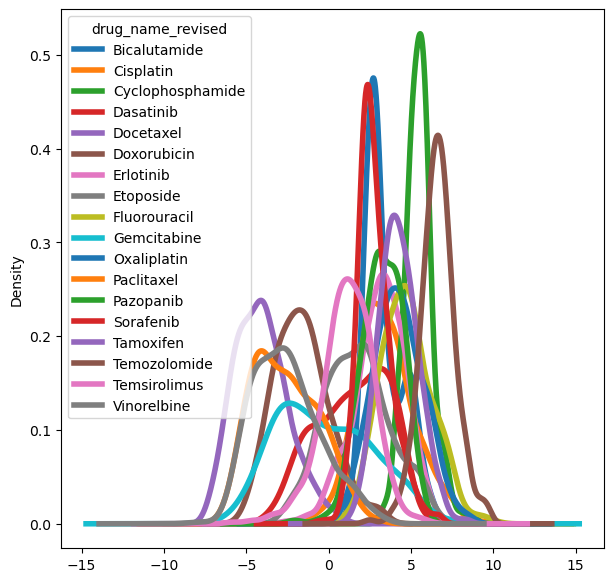

In [40]:
# distribution of drugs
ic50_gdsc_v3_pivoted = ic50_gdsc_v3.pivot(index="SANGER_MODEL_ID", columns="drug_name_revised", values="LN_IC50")
print(f'ic50_gdsc_v3_pivoted.shape: {ic50_gdsc_v3_pivoted.shape}')

# plot
ic50_gdsc_v3_pivoted.plot.density(figsize = (7, 7), linewidth = 4)
# conclusion: 2 parts: 1st part has low IC50, 2nd part have high IC50

# intergrate SNV, GEP, pheno, and IC50 of gdsc

## raw data and preprocess

In [46]:
# raw data
# ic50
print(ic50_gdsc_v3.head(2))
# snv
snv_gdsc_raw = pd.read_csv("../data_input/GDSC/mutations_all_20230202.zip") # the full version
#
# GEP of gdsc: raw data
tpm_gdsc = pd.read_csv("../data_input/GDSC/rnaseq_tpm_20220624.csv", dtype = 'str')
print(f'tpm_gdsc.shape: {tpm_gdsc.shape}')

  SANGER_MODEL_ID drug_name_revised   LN_IC50  PatientID CellLineName  \
0       SIDM00003      Bicalutamide  2.619632  PT-3NwoWt          M14   
1       SIDM00003         Cisplatin  2.935488  PT-3NwoWt          M14   

  StrippedCellLineName   Age SourceType SangerModelID       RRID  ...  \
0                  M14  33.0        NaN     SIDM00003  CVCL_1395  ...   
1                  M14  33.0        NaN     SIDM00003  CVCL_1395  ...   

   CCLEName  COSMICID PublicComments WTSIMasterCellID OncotreeCode  \
0  M14_SKIN  905975.0            NaN            586.0          MEL   
1  M14_SKIN  905975.0            NaN            586.0          MEL   

  OncotreeSubtype OncotreePrimaryDisease  OncotreeLineage OncotreeCode_CCLE  \
0        Melanoma               Melanoma             Skin               MEL   
1        Melanoma               Melanoma             Skin               MEL   

   cancerType_TCGA  
0             SKCM  
1             SKCM  

[2 rows x 28 columns]
tpm_gdsc.shape: (37606, 1

In [3]:
snv_gdsc_raw.head()

,gene_id,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name
0,SIDG17159,MAN1A2,SIDM01279,-,r.?,-,False,False,intronic,0.2973,False,Sanger,HCM-SANG-0269-C18
1,SIDG36607,ST8SIA5,SIDM02021,-,r.?,-,False,False,intronic,0.3889,False,Sanger,HCM-SANG-1082-C15
2,SIDG16700,LONRF2,SIDM02021,-,r.?,-,False,False,downstream,0.4667,False,Sanger,HCM-SANG-1082-C15
3,SIDG09188,FLRT2,SIDM01954,-,r.?,-,False,False,intronic,1.0000,False,Sanger,HCM-SANG-0537-C18
4,SIDG21177,MYO1E,SIDM01954,-,r.?,-,False,False,intronic,0.3611,False,Sanger,HCM-SANG-0537-C18


In [4]:
snv_gdsc_raw.effect.unique()

array(['intronic', 'downstream', 'upstream', '3prime_UTR_variant',
       '5prime_UTR_variant', 'missense', 'frameshift', 'ess_splice',
       'splice_region', 'inframe', 'nc_variant', '5prime_UTR_ess_splice',
       'nonsense', 'silent', 'stop_lost', '3prime_UTR_ess_splice',
       'start_lost',
       'SO:0000010:protein_coding,SO:0000147:exon,SO:0000205:three_prime_UTR,SO:0000316:CDS,SO:0000159:deletion,SO:0001634:500B_downstream_variant,SO:0001577:complex_change_in_transcript,SO:0001576:transcript_variant,SO:0001578:stop_lost',
       'complex_sub', 'cds_disrupted', 'nc_ess_splice',
       'SO:0000010:protein_coding,SO:0000188:intron,SO:0000205:three_prime_UTR,SO:0001996:extended_intronic_splice_region,SO:0000159:deletion,SO:0001624:3_prime_UTR_variant,SO:0001995:extended_intronic_splice_region_variant,SO:0001627:intron_variant,SO:0001576:transcript_variant',
       'SO:0000011:non_protein_coding,SO:0001993:extended_cis_splice_site,SO:0001996:extended_intronic_splice_region,SO:1000

In [47]:
# preprocess: snv

vc = ['missense', 'frameshift', 'inframe', 'nonsense','stop_lost', 'start_lost', 'protein_coding']
pat = "|".join(vc)
print(pat)

mask_vc = snv_gdsc_raw.effect.str.contains(pat)
print(f"mask_vc.sum: {mask_vc.sum()}")

mask_proteinCoding = snv_gdsc_raw.effect.str.contains("protein_coding")
print(f"mask_proteinCoding.sum: {mask_proteinCoding.sum()}")

snv_gdsc_preprocessed = snv_gdsc_raw.loc[mask_vc, :]
print(f"snv_gdsc_preprocessed.shape: {snv_gdsc_preprocessed.shape}")

missense|frameshift|inframe|nonsense|stop_lost|start_lost|protein_coding
mask_vc.sum: 1341990
mask_proteinCoding.sum: 636
snv_gdsc_preprocessed.shape: (1341990, 13)


In [48]:
# proprocess: gep
tpm_gdsc_modelID = tpm_gdsc.columns[2::]
tpm_gdsc_gene_symbol = tpm_gdsc.iloc[4::, 1].values
tpm_gdsc_preprocessed = tpm_gdsc.iloc[4::, 2::]
tpm_gdsc_preprocessed.columns = tpm_gdsc_modelID
tpm_gdsc_preprocessed.index = tpm_gdsc_gene_symbol
print(f'tpm_gdsc_preprocessed.shape: {tpm_gdsc_preprocessed.shape}')

tpm_gdsc_preprocessed.shape: (37602, 1431)


## driver gene filtering

In [49]:
from functools import reduce

In [44]:
# driver genes defined by gdsc
df_driverG = pd.read_csv("../data_input/GDSC/driver_genes_20221018.csv")
print(df_driverG.head(2))
print(df_driverG.symbol.duplicated().any()) # No duplication, good
#
arr_driverG = df_driverG.symbol
print(f'# of driver genes: {len(arr_driverG)}')

# tpm tcga
print(tpm_tcga_v1.head(2))
# tpm ccle
tpm_ccle = pd.read_csv(os.path.join("../data_input/ccle/data_20Q4", "CCLE_expression_full.csv"))

  symbol method_of_action   cosmic_moa intogen_moa    gene_id
0  ABCB1              Act          NaN         Act  SIDG00064
1   ABI1        ambiguous  TSG, fusion   ambiguous  SIDG00145
False
# of driver genes: 783
             TCGA-19-1787  TCGA-S9-A7J2  TCGA-G3-A3CH  TCGA-EK-A2RE  \
gene_symbol                                                           
LINC02082         -9.9658        0.2998       -9.9658       -9.9658   
ST8SIA5-DT        -3.8160       -3.0469       -9.9658       -9.9658   

             TCGA-44-6778  TCGA-F4-6854  TCGA-AB-2863  TCGA-C8-A1HL  \
gene_symbol                                                           
LINC02082         -9.9658       -9.9658       -9.9658       -9.9658   
ST8SIA5-DT        -5.5735       -9.9658       -3.4580       -9.9658   

             TCGA-EW-A2FS  TCGA-IR-A3L7  ...  TCGA-A8-A09K  TCGA-61-1907  \
gene_symbol                              ...                               
LINC02082         -9.9658       -9.9658  ...       -9.9658     

In [50]:
# id.model intersection in gdsc: ic50, snv, tpm

id_inter_gdsc = reduce(np.intersect1d,
                       [ic50_gdsc_v3.SANGER_MODEL_ID.unique(),
                        snv_gdsc_preprocessed.model_id.unique(),
                        tpm_gdsc_preprocessed.columns.unique()]
                       )

print(f"ic50_gdsc_v3.SANGER_MODEL_ID.unique().shape: {ic50_gdsc_v3.SANGER_MODEL_ID.unique().shape}")
print(f"snv_gdsc_preprocessed.model_id.unique().shape: {snv_gdsc_preprocessed.model_id.unique().shape}")
print(f"tpm_gdsc_preprocessed.columns.unique().shape: {tpm_gdsc_preprocessed.columns.unique().shape}")
print(f"id_inter_gdsc.shape: {id_inter_gdsc.shape}")

ic50_gdsc_v3.SANGER_MODEL_ID.unique().shape: (548,)
snv_gdsc_preprocessed.model_id.unique().shape: (1435,)
tpm_gdsc_preprocessed.columns.unique().shape: (1431,)
id_inter_gdsc.shape: (542,)


In [51]:
# gene intersection among arr_driverG, gdsc, ccle, and tcga 
gene_gep_ccle = tpm_ccle.columns.str.extract("([^ (]+)", expand = False).astype(str)
geneInter_4sets = reduce(np.intersect1d, 
                                     [arr_driverG,
                                      tpm_gdsc_preprocessed.index, 
                                      tpm_tcga_v1.index,
                                      gene_gep_ccle])
print(f"arr_driverG.shape: {arr_driverG.shape}")
print(f"geneInter_4sets length: {len(geneInter_4sets)}")

arr_driverG.shape: (783,)
geneInter_4sets length: 776


In [31]:
# save
# np.save("../output/out_gdsc/id_inter_gdsc.npy", id_inter_gdsc)
# np.save("../output/out_gdsc/geneInter_4sets.npy", geneInter_4sets)

In [110]:
# can i use gep_tpm_ccle to create gep_tpm_gdsc?
# n_saple = gep_tpm_ccle.index.isin(ic50_gdsc_v3.ModelID.unique()).sum()
# print(n_saple)
# No, i can't, becuase gep_tpm_ccle only contains 465 samples that belong to gdsc

In [52]:
# snv process: filter, to wider format
mask_sample = snv_gdsc_preprocessed.model_id.isin(id_inter_gdsc)
mask_driverG = snv_gdsc_preprocessed.gene_symbol.isin(geneInter_4sets)
print(f"mask_driverG.sum: {mask_driverG.sum()}")

snv_gdsc_v1 = snv_gdsc_preprocessed.loc[mask_sample & mask_driverG, :].drop_duplicates(subset = ["gene_symbol", "model_id"])
snv_gdsc_v1["mutation_status"] = 1
print(f'snv_gdsc_v1.shape: {snv_gdsc_v1.shape}')

snv_gdsc_wide = snv_gdsc_v1.pivot_table(values="mutation_status",
                                index="model_id",
                                columns="gene_symbol",
                                aggfunc='mean',
                                fill_value=0)
print(f"snv_gdsc_wide.shape: {snv_gdsc_wide.shape}")
#
# add the rest driver genes
df_add = pd.DataFrame(columns = np.setdiff1d(geneInter_4sets, snv_gdsc_wide.columns))
print(f"df_add.shape: {df_add.shape}")
snv_gdsc_wide_v1 = pd.concat([snv_gdsc_wide, df_add], axis = 1).fillna(0)
# re-arrange columns to driverGlist
snv_gdsc_wide_v1 = snv_gdsc_wide_v1.loc[id_inter_gdsc, geneInter_4sets]
#
print(f'snv_gdsc_wide_v1.shape: {snv_gdsc_wide_v1.shape}')
# double check
x = snv_gdsc_wide_v1.apply(lambda x: pd.Series(x.unique()).isin([0,1])).all().all()
print(f"x is True?: {x}")

mask_driverG.sum: 83305
snv_gdsc_v1.shape: (24558, 14)
snv_gdsc_wide.shape: (542, 770)
df_add.shape: (0, 6)
snv_gdsc_wide_v1.shape: (542, 776)
x is True?: True


In [53]:
# tmp process:
mask_gene = tpm_gdsc_preprocessed.index.isin(geneInter_4sets)
mask_sample = tpm_gdsc_preprocessed.columns.isin(id_inter_gdsc)
tpm_gdsc_v1 = tpm_gdsc_preprocessed.loc[mask_gene, mask_sample].T.apply(lambda x: x.astype(float))
tpm_gdsc_v1 = tpm_gdsc_v1.apply(lambda x: np.log2(x+0.001))
tpm_gdsc_v1 = tpm_gdsc_v1.loc[id_inter_gdsc, geneInter_4sets]
print(f"tpm_gdsc_v1.shape: {tpm_gdsc_v1.shape}")
# double check
x = tpm_gdsc_v1.apply(lambda x: np.isnan(x).sum() == 0).all()
print(f"x is True?: {x}")

tpm_gdsc_v1.shape: (542, 776)
x is True?: True


In [54]:
tpm_gdsc_v1.head(2)

,ABCB1,ABI1,ABL1,ABL2,ACKR3,ACSL3,ACVR1,ACVR2A,AFDN,AFF1,...,ZNF521,ZNF626,ZNF680,ZNF721,ZNF780A,ZNF814,ZNF93,ZNRF3,ZRSR2,ZXDB
SIDM00003,3.102826,5.790277,6.055304,5.499878,-9.965784,7.255982,5.821481,1.718526,4.152265,4.291383,...,3.669140,-3.307573,2.891614,2.582797,2.982035,0.848798,0.669934,-0.394032,4.493199,2.799295
SIDM00023,-9.965784,6.122693,5.777183,3.826904,6.473641,5.576250,3.955220,2.134550,4.393759,3.482977,...,-5.011588,-3.307573,3.897337,3.612470,2.989321,-1.282790,0.240009,0.357270,2.971038,3.393828


In [24]:
print(tpm_gdsc_v1.min().describe())
print(tpm_gdsc_v1.max().describe())

count    776.000000
mean      -3.379382
std        5.659408
min       -9.965784
25%       -9.965784
50%       -2.465938
75%        1.725082
max        8.512428
dtype: float64
count    776.000000
mean       7.676777
std        1.983155
min       -3.171368
25%        6.545165
50%        7.582826
75%        8.777382
max       14.252104
dtype: float64


In [55]:
# ic50 process:
ic50_gdsc_v4 = ic50_gdsc_v3.loc[ic50_gdsc_v3.SANGER_MODEL_ID.isin(id_inter_gdsc), :]
print(f"ic50_gdsc_v3.shape: {ic50_gdsc_v3.shape}")
print(f"ic50_gdsc_v4.shape: {ic50_gdsc_v4.shape}")

ic50_gdsc_v3.shape: (9653, 28)
ic50_gdsc_v4.shape: (9553, 28)


In [56]:
ic50_gdsc_v4.drug_name_revised.unique().shape

(18,)

In [57]:
# pivot ic50_gdsc_v4 and process NAs in it
ic50_gdsc_v4_pivoted = ic50_gdsc_v4.pivot(index="SANGER_MODEL_ID",
                                          columns="drug_name_revised",
                                          values="LN_IC50")
print(f"ic50_gdsc_v4_pivoted.shape: {ic50_gdsc_v4_pivoted.shape}")

# check NAs
x = ic50_gdsc_v4_pivoted.apply(lambda x: x.isna().sum())
print(x)

# replace NA with mean values in each columns
def replace_na_with_mean(ser):
    mean_value = ser.mean()
    ser1 = np.where(ser.isna(), mean_value, ser)
    return (ser1)

ic50_gdsc_wide = ic50_gdsc_v4_pivoted.apply(replace_na_with_mean)
ic50_gdsc_wide = ic50_gdsc_wide.loc[id_inter_gdsc, :]

print(f'ic50_gdsc_wide.shape: {ic50_gdsc_wide.shape}')
# double check
x = ic50_gdsc_wide.apply(lambda x: x.isna().any())
print(x.any())

ic50_gdsc_v4_pivoted.shape: (542, 18)
drug_name_revised
Bicalutamide         4
Cisplatin           12
Cyclophosphamide    13
Dasatinib            4
Docetaxel            2
Doxorubicin          8
Erlotinib            5
Etoposide           59
Fluorouracil         3
Gemcitabine          2
Oxaliplatin          7
Paclitaxel           4
Pazopanib           63
Sorafenib            5
Tamoxifen            2
Temozolomide         2
Temsirolimus         4
Vinorelbine          4
dtype: int64
ic50_gdsc_wide.shape: (542, 18)
False


In [58]:
# pheno process

col_use = ['SANGER_MODEL_ID', 'Age', 'Sex', 'cancerType_TCGA']
pheno_gdsc = ic50_gdsc_v4.loc[:, col_use].drop_duplicates()
print("pheno_gdsc.shape: {}".format(pheno_gdsc.shape))

# NAs
print(pheno_gdsc.Sex.value_counts())
mask_age = pheno_gdsc.Age.isna()
mask_sex = (pheno_gdsc.Sex == "Unknown")
print(f"# NAs in Age: {mask_age.sum()}")
print(f"# NAs in sex: {mask_sex.sum()}")

# fill NAs in sex by random, in age by mean age

rng = np.random.default_rng(0)
x = rng.choice(["Male", "Female"], size=24, replace=True, 
           p=[260/(260+229), 229/(260+229)], axis=0, shuffle=True)
pheno_gdsc_v1 = pheno_gdsc.sort_values("Sex", ascending = False)
pheno_gdsc_v1["Sex"].iloc[0:24] = x

age_median = pheno_gdsc_v1.Age.median().astype(int)
pheno_gdsc_v1["Age"] = np.where(pheno_gdsc_v1.Age.isna(), 
                                age_median,
                                 pheno_gdsc_v1.Age)
print(pheno_gdsc_v1.Age.describe())

# double check NAs
check1 = pheno_gdsc_v1.apply(lambda x: x.isna().sum() == 0)
print(check1)

pheno_gdsc_v1 = pheno_gdsc_v1.set_index("SANGER_MODEL_ID").loc[id_inter_gdsc, :]
pheno_gdsc_dummy = pd.get_dummies(data = pheno_gdsc_v1, columns = ["Sex", "cancerType_TCGA"])
print(f"pheno_gdsc_dummy.shape: {pheno_gdsc_dummy.shape}")
print(f"pheno_gdsc_dummy.columns: {pheno_gdsc_dummy.columns}")

pheno_gdsc.shape: (542, 4)
Male       279
Female     239
Unknown     24
Name: Sex, dtype: int64
# NAs in Age: 88
# NAs in sex: 24
count    542.000000
mean      52.057196
std       16.080391
min        0.000000
25%       46.000000
50%       54.000000
75%       62.000000
max       89.000000
Name: Age, dtype: float64
SANGER_MODEL_ID    True
Age                True
Sex                True
cancerType_TCGA    True
dtype: bool
pheno_gdsc_dummy.shape: (542, 15)
pheno_gdsc_dummy.columns: Index(['Age', 'Sex_Female', 'Sex_Male', 'cancerType_TCGA_BRCA',
       'cancerType_TCGA_COAD', 'cancerType_TCGA_ESCA', 'cancerType_TCGA_GBM',
       'cancerType_TCGA_HNSC', 'cancerType_TCGA_KIRC', 'cancerType_TCGA_LUAD',
       'cancerType_TCGA_OV', 'cancerType_TCGA_PAAD', 'cancerType_TCGA_SARC',
       'cancerType_TCGA_SCLC', 'cancerType_TCGA_SKCM'],
      dtype='object')


/tmp/ipykernel_3594/2989015464.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_gdsc_v1["Sex"].iloc[0:24] = x


In [59]:
# save driver gene filtered 
driverG_filtered = df_driverG.loc[df_driverG.symbol.isin(tpm_gdsc_v1.columns), :]
print(f'driverG_filtered.shape: {driverG_filtered.shape}')

,Age,Sex,cancerType_TCGA
SANGER_MODEL_ID,,,
SIDM00003,33.0,Male,SKCM
SIDM00023,54.0,Male,ESCA


In [63]:
# save, 20230808
ic50_gdsc_wide.to_csv("../data_temp/ic50_gdsc_wide.csv", index = True)
ic50_gdsc_v4.to_csv("../data_temp/ic50_gdsc_v4.csv", index = False)
pheno_gdsc_dummy.to_csv("../data_temp/pheno_gdsc_dummy.csv", index = True)
pheno_gdsc_v1.to_csv("../data_temp/pheno_gdsc_v1.csv", index = True)
snv_gdsc_wide_v1.to_csv("../data_temp/snv_gdsc_wide_v1.csv", index = True)
tpm_gdsc_v1.to_csv("../data_temp/tpm_gdsc_v1.csv", index = True)
driverG_filtered.to_csv("../data_temp/driverG_filtered.csv")

# drug: with smile

In [69]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

In [5]:
# import rdkit
# print(rdkit.__version__)

In [65]:
#
print(ic50_gdsc_v4.head(2))
# smiles, previously prepared
drug_smiles = pd.read_csv("../data_input/drug/drug_use_v2_manualAdd.csv")
print("drug_smiles.shape: {}".format(drug_smiles.shape))

  SANGER_MODEL_ID drug_name_revised   LN_IC50  PatientID CellLineName  \
0       SIDM00003      Bicalutamide  2.619632  PT-3NwoWt          M14   
1       SIDM00003         Cisplatin  2.935488  PT-3NwoWt          M14   

  StrippedCellLineName   Age SourceType SangerModelID       RRID  ...  \
0                  M14  33.0        NaN     SIDM00003  CVCL_1395  ...   
1                  M14  33.0        NaN     SIDM00003  CVCL_1395  ...   

   CCLEName  COSMICID PublicComments WTSIMasterCellID OncotreeCode  \
0  M14_SKIN  905975.0            NaN            586.0          MEL   
1  M14_SKIN  905975.0            NaN            586.0          MEL   

  OncotreeSubtype OncotreePrimaryDisease  OncotreeLineage OncotreeCode_CCLE  \
0        Melanoma               Melanoma             Skin               MEL   
1        Melanoma               Melanoma             Skin               MEL   

   cancerType_TCGA  
0             SKCM  
1             SKCM  

[2 rows x 28 columns]
drug_smiles.shape: (10, 1

In [70]:
# smile
drug_use = ic50_gdsc_v4.drug_name_revised.unique()
# print(f'drug_use: {drug_use}')
#
df_smile_1 = drug_smiles.loc[:, ["drug_name_revised", "SMILES_PubChem"]]
df_smile_1 = df_smile_1.loc[df_smile_1.drug_name_revised.isin(drug_use), :]
drug_need_smile = np.setdiff1d(drug_use, df_smile_1.drug_name_revised)
print(drug_need_smile)

# smile
smile_add = {'Bicalutamide': "CC(CS(=O)(=O)C1=CC=C(C=C1)F)(C(=O)NC2=CC(=C(C=C2)C#N)C(F)(F)F)O",
 'Dasatinib':"CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(=N3)C)N4CCN(CC4)CCO",
 'Erlotinib':"COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C)OCCOC",
 'Pazopanib':"CC1=C(C=C(C=C1)NC2=NC=CC(=N2)N(C)C3=CC4=NN(C(=C4C=C3)C)C)S(=O)(=O)N",
 'Sorafenib':"CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC(=C(C=C3)Cl)C(F)(F)F",
 'Tamoxifen':"CC/C(=C(\C1=CC=CC=C1)/C2=CC=C(C=C2)OCCN(C)C)/C3=CC=CC=C3",
 'Temsirolimus':"C[C@@H]1CC[C@H]2C[C@@H](/C(=C/C=C/C=C/[C@H](C[C@H](C(=O)[C@@H]([C@@H](/C(=C/[C@H](C(=O)C[C@H](OC(=O)[C@@H]3CCCCN3C(=O)C(=O)[C@@]1(O2)O)[C@H](C)C[C@@H]4CC[C@H]([C@@H](C4)OC)OC(=O)C(C)(CO)CO)C)/C)O)OC)C)C)/C)OC",
 'Vinorelbine':"CCC1=C[C@H]2C[C@@](C3=C(CN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)[C@]78CCN9[C@H]7[C@@](C=CC9)([C@H]([C@@]([C@@H]8N6C)(C(=O)OC)O)OC(=O)C)CC)OC)C(=O)OC"
}
#
df_smile_add = pd.DataFrame.from_dict(smile_add, orient = "index").reset_index()
df_smile_add.columns = df_smile_1.columns
#
df_smile_full = pd.concat([df_smile_1, df_smile_add])
print(f"df_smile_full.shape: {df_smile_full.shape}")

['Bicalutamide' 'Dasatinib' 'Erlotinib' 'Pazopanib' 'Sorafenib'
 'Tamoxifen' 'Temsirolimus' 'Vinorelbine']
df_smile_full.shape: (18, 2)


In [71]:
df_smile_full.head(2)

,drug_name_revised,SMILES_PubChem
0,Paclitaxel,CC1=C2[C@H](C(=O)[C@]3([C@H](C[C@@H]4[C@@](C3[...
1,Doxorubicin,C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](CC...


In [72]:
# generate fingeprints

# generate molecules
ms = []
for drug in df_smile_full.drug_name_revised:
    smile = df_smile_full.loc[df_smile_full.drug_name_revised == drug, "SMILES_PubChem"].iloc[0]
    m = Chem.MolFromSmiles(smile)
    ms.append(m)

# generate fingeprints: Morgan fingerprint with radius 2
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, 512) for m in ms]

# convert the RDKit explicit vectors into numpy arrays
np_fps = []
for fp in fps:
  arr = np.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  np_fps.append(arr)

In [73]:
# revise 
df_fingerprints = pd.DataFrame(np_fps, dtype = "int")
df_fingerprints.index = df_smile_full.drug_name_revised
df_fingerprints.columns = "f_" + df_fingerprints.columns.astype(str)

In [74]:
df_fingerprints.head(2)

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_502,f_503,f_504,f_505,f_506,f_507,f_508,f_509,f_510,f_511
drug_name_revised,,,,,,,,,,,,,,,,,,,,,
Paclitaxel,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
Doxorubicin,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [75]:
# save
df_fingerprints.to_csv("../data_temp/df_fingerprints_18drugs.csv")

# response, pheno, SNV, GEP of TCGA

## ID intersection

In [82]:
# load TCGA data

print(f"ic50_gdsc_v4.shape: {ic50_gdsc_v4.shape}")
print(f"geneInter_4sets.shape: {geneInter_4sets.shape}")

print(f"response_per_pt_tcga_singleDrug.shape: {response_per_pt_tcga_singleDrug.shape}")
print(f"pheno_tcga_raw.shape: {pheno_tcga_raw.shape}")
print(f'snv_nonsilence_tcga.shape: {snv_nonsilence_tcga.shape}')
print(f'tpm_tcga_v1.shape: {tpm_tcga_v1.shape}')

ic50_gdsc_v4.shape: (9553, 28)
geneInter_4sets.shape: (776,)
response_per_pt_tcga_singleDrug.shape: (404, 2)
pheno_tcga_raw.shape: (10967, 99)
snv_nonsilence_tcga.shape: (40543, 9104)
tpm_tcga_v1.shape: (38502, 10536)


In [84]:
# filter response by drug, filter cancer type by pheno
inter_drug_a = np.intersect1d(response_per_pt_tcga_singleDrug.drug_name,
                              ic50_gdsc_v4.drug_name_revised)
print(f"inter_drug_a.shape: {inter_drug_a.shape}")
response_tcga_v1 = response_per_pt_tcga_singleDrug.loc[response_per_pt_tcga_singleDrug.drug_name.isin(inter_drug_a), :]
print(f"response_tcga_v1.shape: {response_tcga_v1.shape}")

inter_cancer_a = np.intersect1d(pheno_tcga_raw['TCGA PanCanAtlas Cancer Type Acronym'],
                                ic50_gdsc_v4.cancerType_TCGA)
print(f"inter_cancer_a.shape: {inter_cancer_a.shape}")
pheno_tcga_v1 = pheno_tcga_raw.loc[pheno_tcga_raw['TCGA PanCanAtlas Cancer Type Acronym'].isin(inter_cancer_a), :]
print(f"pheno_tcga_v1.shape: {pheno_tcga_v1.shape}")

inter_drug_a.shape: (18,)
response_tcga_v1.shape: (297, 2)
inter_cancer_a.shape: (11,)
pheno_tcga_v1.shape: (5370, 99)


In [85]:
# intersected IDs

# pt_barcode_snv
mask_frozen_snv = snv_nonsilence_tcga.columns.str.endswith("01")
pt_barcode_snvFrozen = snv_nonsilence_tcga.columns[mask_frozen_snv].str[0:12]

pt_barcode_snvFull = snv_nonsilence_tcga.columns.str[0:12].drop_duplicates()

# pt_barcode_response
pt_snvFrozen_response = np.intersect1d(pt_barcode_snvFrozen, 
                                response_tcga_v1.bcr_patient_barcode.unique())
pt_snvFull_response = np.intersect1d(pt_barcode_snvFull, 
                                response_tcga_v1.bcr_patient_barcode.unique())

print(f"pt reponse.shape: {response_tcga_v1.bcr_patient_barcode.unique().shape}")
print(f"pt_snvFrozen_response.shape: {pt_snvFrozen_response.shape}")
print(f"pt_snvFull_response.shape: {pt_snvFull_response.shape}")

pt reponse.shape: (297,)
pt_snvFrozen_response.shape: (294,)
pt_snvFull_response.shape: (297,)


In [86]:
# pt_barcode_rna
pt_rna_response = np.intersect1d(tpm_tcga_v1.columns, 
                                response_tcga_v1.bcr_patient_barcode.unique())

print(f"pt reponse.shape: {response_tcga_v1.bcr_patient_barcode.unique().shape}")
print(f"pt_rna_response.shape: {pt_rna_response.shape}")

pt reponse.shape: (297,)
pt_rna_response.shape: (297,)


In [87]:
# intersection
pt_barcode_inter4d_tcga = reduce(np.intersect1d,
    [pheno_tcga_v1['Patient ID'].unique(), pt_snvFrozen_response, pt_rna_response])

print(f"pt_barcode_inter4d_tcga.shape: {pt_barcode_inter4d_tcga.shape}")

pt_barcode_inter4d_tcga.shape: (105,)


## process response

In [88]:
drug_response_tcga.head(2)

,Cancer,bcr_patient_barcode,drug_name,DrugBank ID,measure_of_response,days_to_drug_therapy_start,days_to_drug_therapy_end,days_to_initial_pathologic_diagnosis,method_of_sample_procurement,days_to_sample_procurement,days_to_new_tumor_event_after_initial_treatment,additional_pharmaceutical_therapy,new_tumor_event_additional_surgery_procedure,history_of_neoadjuvant_treatment
0,Adrenocortical carcinoma (ACC),TCGA-OR-A5JM,Sunitinib,DB01268,Clinical Progressive Disease,378,439,0.0,Surgical Resection,1.0,72.0,YES,NO,Yes
1,Adrenocortical carcinoma (ACC),TCGA-OR-A5JM,Ketoconazole,DB01026,Clinical Progressive Disease,378,439,0.0,Surgical Resection,1.0,72.0,YES,NO,Yes


In [89]:
response_tcga_v1.head(2)

,bcr_patient_barcode,drug_name
50,TCGA-2L-AAQA,Gemcitabine
51,TCGA-2L-AAQE,Gemcitabine


In [90]:
response_tcga_v2 = response_tcga_v1.loc[response_tcga_v1.bcr_patient_barcode.isin(pt_barcode_inter4d_tcga), :]
response_tcga_v2 = pd.merge(drug_response_tcga,
                            response_tcga_v2,
                           left_on = ["bcr_patient_barcode", "drug_name"],
                           right_on = ["bcr_patient_barcode", "drug_name"],
                           how = "inner")
print(f"response_tcga_v2.shape: {response_tcga_v2.shape}")

# check duplication
x = response_tcga_v2.duplicated(["bcr_patient_barcode", "drug_name"]).sum()
print("#dup: {x}")

# check pts, drugs
n_pts = response_tcga_v2.bcr_patient_barcode.unique().shape
drugs_in_use = response_tcga_v2.drug_name.unique()
print(f"n_pts: {n_pts}")
print(f"n drugs_in_use: {drugs_in_use.shape}")
print(f"drugs_in_use: {drugs_in_use}")

response_tcga_v2.shape: (105, 14)
#dup: {x}
n_pts: (105,)
n drugs_in_use: (13,)
drugs_in_use: ['Tamoxifen' 'Cyclophosphamide' 'Paclitaxel' 'Docetaxel' 'Fluorouracil'
 'Oxaliplatin' 'Etoposide' 'Cisplatin' 'Temsirolimus' 'Pazopanib'
 'Erlotinib' 'Gemcitabine' 'Doxorubicin']


In [91]:
# double check duplications
response_tcga_v2.bcr_patient_barcode.duplicated().sum()

0

## process pheno

In [94]:
# load pheno_gdsc_dummy 
print(f"pheno_gdsc_dummy.shape: {pheno_gdsc_dummy.shape}")

pheno_gdsc_dummy.shape: (542, 15)


In [95]:
pheno_gdsc_dummy.columns

Index(['Age', 'Sex_Female', 'Sex_Male', 'cancerType_TCGA_BRCA',
       'cancerType_TCGA_COAD', 'cancerType_TCGA_ESCA', 'cancerType_TCGA_GBM',
       'cancerType_TCGA_HNSC', 'cancerType_TCGA_KIRC', 'cancerType_TCGA_LUAD',
       'cancerType_TCGA_OV', 'cancerType_TCGA_PAAD', 'cancerType_TCGA_SARC',
       'cancerType_TCGA_SCLC', 'cancerType_TCGA_SKCM'],
      dtype='object')

In [96]:
# pheno

pheno_tcga_v2 = pheno_tcga_v1.loc[pheno_tcga_v1['Patient ID'].isin(pt_barcode_inter4d_tcga), :]
print(f"pheno_tcga_v2.shape: {pheno_tcga_v2.shape}")

pheno_tcga_v2.shape: (105, 99)


In [97]:
# pheno_tcga_v2 dummy
print(pheno_tcga_v2.Sex.isna().sum())
print(pheno_tcga_v2.Sex.value_counts())

pheno_tcga_v2["Age"] =  pheno_tcga_v2['Diagnosis Age']
pheno_tcga_v2['cancerType_TCGA'] = pheno_tcga_v2['TCGA PanCanAtlas Cancer Type Acronym']

cols_tcga = ['Patient ID', 'Age', 'Sex', 'cancerType_TCGA']
pheno_tcga_v2_dummy = pheno_tcga_v2.loc[:, cols_tcga].set_index('Patient ID', drop = True)
print(f"pheno_tcga_v2_dummy.shape: {pheno_tcga_v2_dummy.shape}")

pheno_tcga_v2_dummy = pd.get_dummies(data=pheno_tcga_v2_dummy, 
                                     columns = ["Sex", "cancerType_TCGA"], dummy_na = False)
print(f"pheno_tcga_v2_dummy.shape: {pheno_tcga_v2_dummy.shape}")
print(f"pheno_tcga_v2_dummy.columns: {pheno_tcga_v2_dummy.columns}")

# add col_diff to pheno_tcga_dummy
col_diff = np.setdiff1d(pheno_gdsc_dummy.columns, pheno_tcga_v2_dummy.columns)
print(f"col_diff.shape: {col_diff.shape}")
print(f"col_diff: {col_diff}")

pheno_add = pd.DataFrame(np.zeros(shape=(pheno_tcga_v2_dummy.shape[0], len(col_diff))), 
                         columns = col_diff,
                        index = pheno_tcga_v2_dummy.index)
print(f"pheno_add.shape: {pheno_add.shape}")
pheno_tcga_v2_dummy = pd.concat([pheno_tcga_v2_dummy, pheno_add], axis = 1)
print(f"pheno_tcga_v2_dummy.shape: {pheno_tcga_v2_dummy.shape}")

0
Male      69
Female    36
Name: Sex, dtype: int64
pheno_tcga_v2_dummy.shape: (105, 3)
pheno_tcga_v2_dummy.shape: (105, 11)
pheno_tcga_v2_dummy.columns: Index(['Age', 'Sex_Female', 'Sex_Male', 'cancerType_TCGA_BRCA',
       'cancerType_TCGA_COAD', 'cancerType_TCGA_ESCA', 'cancerType_TCGA_HNSC',
       'cancerType_TCGA_KIRC', 'cancerType_TCGA_LUAD', 'cancerType_TCGA_PAAD',
       'cancerType_TCGA_SARC'],
      dtype='object')
col_diff.shape: (4,)
col_diff: ['cancerType_TCGA_GBM' 'cancerType_TCGA_OV' 'cancerType_TCGA_SCLC'
 'cancerType_TCGA_SKCM']
pheno_add.shape: (105, 4)
pheno_tcga_v2_dummy.shape: (105, 15)


/tmp/ipykernel_3594/2960597829.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_tcga_v2["Age"] =  pheno_tcga_v2['Diagnosis Age']
/tmp/ipykernel_3594/2960597829.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_tcga_v2['cancerType_TCGA'] = pheno_tcga_v2['TCGA PanCanAtlas Cancer Type Acronym']


## process snv

In [99]:
snv_nonsilence_tcga.head(2)

,TCGA-02-0003-01,TCGA-02-0033-01,TCGA-02-0047-01,TCGA-02-0055-01,TCGA-02-2470-01,TCGA-02-2483-01,TCGA-02-2485-01,TCGA-02-2486-01,TCGA-04-1353-01,TCGA-04-1369-01,...,TCGA-ZP-A9D4-01,TCGA-ZQ-A9CR-01,TCGA-ZR-A9CJ-01,TCGA-ZS-A9CD-01,TCGA-ZS-A9CE-01,TCGA-ZS-A9CF-01,TCGA-ZS-A9CG-01,TCGA-ZT-A8OM-01,TCGA-ZU-A8S4-01,TCGA-ZX-AA5X-01
sample,,,,,,,,,,,,,,,,,,,,,
UBE2Q2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHMP1B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
mask_frozen_snv = snv_nonsilence_tcga.columns.str.endswith("01")
inter_driverG = np.intersect1d(snv_nonsilence_tcga.index.unique().astype(str), geneInter_4sets)
diff_driverG = np.setdiff1d(geneInter_4sets, inter_driverG)
print(f"diff_driverG: {diff_driverG}")
snv_tcga_v1 = snv_nonsilence_tcga.loc[snv_nonsilence_tcga.index.isin(inter_driverG), mask_frozen_snv]
snv_tcga_v1.columns = snv_tcga_v1.columns.str[0:12]
#
snv_tcga_v1 = snv_tcga_v1.loc[:, snv_tcga_v1.columns.isin(pt_barcode_inter4d_tcga)]
print(f"snv_tcga_v1.shape: {snv_tcga_v1.shape}")

snv_add = pd.DataFrame(np.zeros(shape=(diff_driverG.shape[0], snv_tcga_v1.shape[1])), 
                      index = diff_driverG,
                      columns = snv_tcga_v1.columns)
snv_tcga_v1 = pd.concat([snv_tcga_v1, snv_add], axis = 0).T
snv_tcga_v1 = snv_tcga_v1.loc[pt_barcode_inter4d_tcga, geneInter_4sets]
print(f"snv_tcga_v1.shape: {snv_tcga_v1.shape}")

# DOUBLE CHECK NAs
x = snv_tcga_v1.isna().sum().sum()
print(f"#NAs: {x}")

diff_driverG: ['AFDN' 'CARS1' 'CEP43' 'H3-3A' 'H3-3B' 'H4C9' 'KNL1' 'MRTFA' 'NSD2'
 'NSD3' 'SEPTIN9' 'TENT5C' 'WDCP']
snv_tcga_v1.shape: (763, 105)
snv_tcga_v1.shape: (105, 776)
#NAs: 0


In [101]:
snv_tcga_v1.head(2)

,ABCB1,ABI1,ABL1,ABL2,ACKR3,ACSL3,ACVR1,ACVR2A,AFDN,AFF1,...,ZNF521,ZNF626,ZNF680,ZNF721,ZNF780A,ZNF814,ZNF93,ZNRF3,ZRSR2,ZXDB
TCGA-2L-AAQA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-2L-AAQE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## process gep

In [102]:
tpm_tcga_v1.head(2)

,TCGA-19-1787,TCGA-S9-A7J2,TCGA-G3-A3CH,TCGA-EK-A2RE,TCGA-44-6778,TCGA-F4-6854,TCGA-AB-2863,TCGA-C8-A1HL,TCGA-EW-A2FS,TCGA-IR-A3L7,...,TCGA-A8-A09K,TCGA-61-1907,TCGA-IB-7885,TCGA-95-7947,TCGA-VQ-AA6F,TCGA-BR-8588,TCGA-24-2254,TCGA-DD-A115,TCGA-FV-A3I0,gene_ensemble
gene_symbol,,,,,,,,,,,,,,,,,,,,,
LINC02082,-9.9658,0.2998,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-1.9379,-9.9658,-9.9658,ENSG00000242268
ST8SIA5-DT,-3.8160,-3.0469,-9.9658,-9.9658,-5.5735,-9.9658,-3.4580,-9.9658,-5.0116,-9.9658,...,-9.9658,-9.9658,-9.9658,-6.5064,-9.9658,-9.9658,-5.5735,-9.9658,-9.9658,ENSG00000270112


In [103]:
# process gep: filter samples and drivr genes

# filter samples
mask_samples = tpm_tcga_v1.columns.isin(pt_barcode_inter4d_tcga)
mask_sample_dup = tpm_tcga_v1.columns.duplicated()
print(f"pt_barcode_inter4d_tcga.shape: {pt_barcode_inter4d_tcga.shape}")
print(f"mask_samples.sum: {mask_samples.sum()}")
print(f"mask_sample_dup.sum: {mask_sample_dup.sum()}")

# select the driver genes
inter_gene = np.intersect1d(tpm_tcga_v1.index, geneInter_4sets)
diff_gene = np.setdiff1d(geneInter_4sets, tpm_tcga_v1.index)
print(f"diff_gene: {diff_gene.shape}")
tpm_tcga_v2 = tpm_tcga_v1.loc[tpm_tcga_v1.index.isin(inter_gene), mask_samples].T
tpm_tcga_v2 = tpm_tcga_v2.loc[pt_barcode_inter4d_tcga, geneInter_4sets]
print(tpm_tcga_v2.shape)

pt_barcode_inter4d_tcga.shape: (105,)
mask_samples.sum: 110
mask_sample_dup.sum: 754
diff_gene: (0,)
(110, 776)


In [64]:
tpm_tcga_v2.head(2)

gene_symbol,ABCB1,ABI1,ABL1,ABL2,ACKR3,ACSL3,ACVR1,ACVR2A,AFDN,AFF1,...,ZNF521,ZNF626,ZNF680,ZNF721,ZNF780A,ZNF814,ZNF93,ZNRF3,ZRSR2,ZXDB
TCGA-2L-AAQA,0.5666,5.3140,4.4516,2.3704,5.3191,6.0588,4.7719,1.8643,5.3456,2.9186,...,1.7744,-0.3201,2.3193,3.7857,3.1442,2.3394,-0.2328,1.3051,3.3221,2.3222
TCGA-2L-AAQE,1.2023,5.1966,4.4932,1.6045,3.0740,4.9644,4.6899,3.5982,4.4183,3.2096,...,2.3308,-0.4921,1.9638,3.4687,4.1310,2.8582,1.5514,0.9115,3.8105,1.5902


## save TCGA temp

In [104]:
# save
response_tcga_v2.to_csv("../data_temp/response_tcga_v2.csv", index = False)

tpm_tcga_v2.to_csv("../data_temp/tpm_tcga_v2.csv", index = True)

pheno_tcga_v2.to_csv("../data_temp/pheno_tcga_v2.csv", index = False)
pheno_tcga_v2_dummy.to_csv("../data_temp/pheno_tcga_v2_dummy.csv", index = True)

snv_tcga_v1.to_csv("../data_temp/snv_tcga_v1.csv", index = True)

# record

In [ ]:
# # drug
# df_fingerprints.to_csv("../data_temp/df_fingerprints_18drugs.csv")

# # GDSC
# ic50_gdsc_wide.to_csv("../data_temp/ic50_gdsc_wide.csv", index = True)
# ic50_gdsc_v4.to_csv("../data_temp/ic50_gdsc_v4.csv", index = False)
# pheno_gdsc_dummy.to_csv("../data_temp/pheno_gdsc_dummy.csv", index = True)
# pheno_gdsc_v1.to_csv("../data_temp/pheno_gdsc_v1.csv", index = True)
# snv_gdsc_wide_v1.to_csv("../data_temp/snv_gdsc_wide_v1.csv", index = True)
# tpm_gdsc_v1.to_csv("../data_temp/tpm_gdsc_v1.csv", index = True)
# driverG_filtered.to_csv("../data_temp/driverG_filtered.csv")

# # TCGA
# response_tcga_v2.to_csv("../data_temp/response_tcga_v2.csv", index = False)

# tpm_tcga_v2.to_csv("../data_temp/tpm_tcga_v2.csv", index = True)

# pheno_tcga_v2.to_csv("../data_temp/pheno_tcga_v2.csv", index = False)
# pheno_tcga_v2_dummy.to_csv("../data_temp/pheno_tcga_v2_dummy.csv", index = True)

# snv_tcga_v1.to_csv("../data_temp/snv_tcga_v1.csv", index = True)